In [2]:
from install import *
install_requirements(chapter=2)

⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.11.3
Using datasets v2.21.0
Using accelerate v0.34.2
Using sentencepiece
Using umap v0.5.6


## 1. 데이터셋

이 데이터셋은 분노, 혐오, 두려움, 기쁨, 슬픔, 놀람 여섯 개의 감정으로 구성됨.

### 1.1 허깅페이스 데이터셋 사용하기

In [3]:
from huggingface_hub import list_datasets

all_datasets = [ds.id for ds in list_datasets()]
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

현재 허브에는 205459개의 데이터셋이 있다.
처음 10개 데이터셋: ['amirveyseh/acronym_identification',
'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa',
'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news',
'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar',
'legacy-datasets/allegro_reviews']


load_dataset() 함수로 emotion 데이터셋 로드

In [4]:
from datasets import load_dataset

emotion = load_dataset("emotion", ignore_verifications=True)

/home/work/.local/lib/python3.8/site-packages/datasets/load.py:2574: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [5]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

이 객체는 파이썬 딕셔너리와 비슷하다.

In [6]:
train_ds = emotion["train"]
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


이 경우 text열의 데이터 타입은 string이고, label열은 클래스 이름과 정수 매핑에 대한 정보가 담긴 특별한 ClassLabel 객체이다.

In [7]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


### 1.2 데이터셋에서 데이터프레임으로

Dataset 객체를 판다스 데이터프레임으로 변환하는 것이 편리할 때가 많다.  
이러한 변환을 위해 허깅페이스 데이터셋은 Dataset의 출력 포맷을 변경하는 `set_format()`메서드를 제공한다.

In [8]:
import pandas as pd

emotion.set_format(type="pandas")
df = emotion["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


레이블이 정수로 출력되므로 features 속성으로 label열을 선택한 후 int2str() 메서드로 레이블 이름에 해당하는 새로운 열을 데이터프레임에 추가하자.

In [9]:
def label_int2str(row):
    return emotion["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


안드레이 카패시는 좋은 모델을 훈련하려면 반드시 '데이터와 하나가 되어야'한다고 말했다.

### 1.3 클래스 분포 살펴보기

분류 문제를 다룰 때는 언제나 샘플의 클래스 분포를 조사하는 것이 좋다.

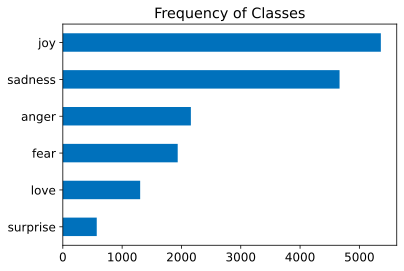

In [10]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

이 데이터셋은 불균형이 심하다. 불균형한 데이터는 다음 방법으로 다룬다.
- 소수 클래스를 랜덤하게 오버샘플링한다.
- 다수 클래스를 랜덤하게 언더샘플링한다.

### 1.4 트윗 길이 확인

트랜스포머 모델은 **최대 문맥 크기**라는 최대 입력 시퀀스 길이가 있다.  
예제에서 사용하는 DistilBERT 모델의 최대문맥크기는 512토큰이다.
트윗당 단어 분포를 보면 감정에 따른 트윗 길이가 대략 추정된다.

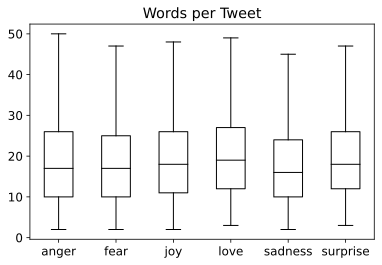

In [11]:
df["Words per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name", grid=False, showfliers=False, color="black")

plt.suptitle("")
plt.xlabel("")
plt.show()

각 감정의 트윗 길이는 15개 단어 정도로 모델의 최대문맥크기보다 더 작다.  

이제 더이상 데이터프레임 포맷이 필요하지 않으니 데이터셋의 출력 포맷을 초기화하자.

In [12]:
emotion.reset_format()

## 2. 텍스트에서 토큰으로

적용할 수 있는 토큰화 전략이 몇 가지 있으며 단어를 부분단위로 나누기 위한 최적 분할은 일반적으로 말뭉치에서 학습된다.  
문자 토큰화와 단어 토큰화라는 두 가지 방식을 살펴보자.

### 2.1 문자 토큰화

가장 간단한 토큰화 방법은 각 문자를 개별로 모델에 주입하는 것.

In [13]:
text = "Tokenizing text is a core task of NLP"
tokenized_text = list(text)

print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P']


모델은 각 문자가 정수로 변환되리라 기대한다. 이런 과정을 `수치화`라 한다. 가장 쉬운 방법은 고유한 각 토큰을 고유한 정후로 인코딩하는 것.

In [14]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9,
'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


어휘사전에 있는 각 문자를 고유한 정수로 바꾸는 매핑 딕셔너리를 만들자. 이제 token2idx를 사용해 토큰화된 텍스트를 정수 리스트로 변환한다.

In [15]:
input_ids = [token2idx[token] for token in tokenized_text]

print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6,
13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


마지막 단계로 input_ids를 원핫벡터의 2D텐서로 바꾸자.

In [16]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))

one_hot_encodings.shape

torch.Size([37, 19])

문자 수준의 토큰화는 텍스트의 구조를 무시하고 전체 문자열을 문자 스트림으로 처리한다는 것을 확인했다.  
이 방식은 철자 오류나 희귀한 단어를 처리하는 데 유용하지만, 단어 같은 언어 구조를 이 데이터에서 학습해야 한다는 큰 단점이 있다.  
이를 위해서는 상당량의 계산, 메모리, 데이터가 필요하다.  
대신, 텍스트의 일부 구조가 유지되는 토큰화를 사용한다. 

### 2.2 단어 토큰화

간단한 단어 토크나이저는 공백을 사용해 텍스트를 토큰화하는 것.

In [17]:
tokenized_text = text.split()

print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


- 그 다음 문자 수준 토큰화에서 수행한 단계를 동일하게 적용해 각 단어를 하나의 ID에 매핑한다.  
- 하지만 이 방법은 구두점이 고려되지 않아 NLP. 이 하나의 토큰으로 처리된다. 이는 어휘사전의 크기 증가로 이어질 수 있다.  
- 어휘사전이 크면 신경망의 파라미터 역시 많아진다.  
- 어휘사전의 크기를 제한하는 일반적인 방법은 드물게 등장하는 단어를 무시하는 것.  
- 어휘사전에 없는 단어는 'unknown'으로 분류해 UNK 토큰으로 매핑한다. 하지만 이러면 큰 정보를 잃게 된다.  

- 이러한 것을 해결하기 위한 방법으로 `부분단어 토큰화`가 제안된다.


### 2.3 부분단어 토큰화

- 부분단어 토큰화는 기본적으로 문자 토큰화와 단어 토큰화의 장점을 결합한 방법.  
- 드물게 등장하는 단어를 더 작은 단위로 나누면 모델이 복잡한 단어나 철자 오류를 처리하기 용이함.
- 널리 사용되는 부분단어 토큰화 중 BERT와 DistilBERT의 토크나이저로 사용되는 WordPiece를 알아보자.

In [18]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

- AutoTokenizer클래스는 체크포인트 이름을 사용하여 모델의 설정, 사전 훈련된 가중치, 어휘 사전을 자동으로 추출하는 자동 클래스

In [19]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [20]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '[SEP]']


세가지 부분을 알아보자.
- [CLS], [SEP]가 시퀀스 처음과 끝에 추가됐다. 이는 시작과 끝을 알리는 토큰이다.
- 토큰이 모두 소문자로 변환됐다. 이것이 이 체크포인트의 특징.
- tokenizing과 NLP가 각각 두개의 토큰으로 나뉘었다. 자주 등장하는 토큰이 아니기 때문이다. #는 앞의 문자열이 공백이 아님을 뜻한다. 이런 접두사가 붙은 토큰은 문자열로 다시 바꿀 때 앞의 토큰과 합친다.

In [21]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp [SEP]


- AutoTokenizer 클래스는 토크나이저에 관한 정보를 제공하는 속성도 몇 가지 있다.

In [22]:
tokenizer.vocab_size

30522

In [23]:
tokenizer.model_max_length

512

In [24]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

- 사전훈련된 모델을 사용할 때, 모델 훈련에 사용한 것과 동일한 토크나이저를 사용하는 것이 정말 중요하다.
- 모델 입장에서 토크나이저를 바꾸는 것은 어휘사전을 뒤섞는 것이나 다름없다.

### 2.4 전체 데이터셋 토큰화하기

- 전체 말뭉치를 토큰화하기 위해 DatasetDict 객체의 map() 메서드를 사용한다.
- 먼저, 샘플을 토큰화할 처리함수가 필요하다.

In [25]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

- 이 함수는 토크나이저를 샘플 배치에 적용한다.
- padding=True로 지정하면 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩함.
- truncation=True로 설정하면 모델의 최대 문맥 크기에 맞춰 샘플을 잘라낸다.

In [26]:
print(tokenize(emotion["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


- 패딩결과를 보면 input_ids의 첫번째 원소가 두번째보다 짧으므로 길이를 동일하게 맞추기 위해 끝에 0을 추가했다. 0은 어휘사전에 있는 [PAD]토큰에 해당한다.
- 토크나이저는 인코딩된 트윗을 input_ids로 반환하고, attention_mask 배열 리스트도 반환한다. 추가된 패딩 토큰때문에 모델이 혼동하지 않게 하려는 조치다.

처리 함수를 정의하면 코드 한 줄로 말뭉치에 있는 모든 분할에 이 과정을 적용할 수 있다.

In [27]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

- 기본적으로 map() 메서드는 말뭉치에 있는 모든 샘플에 개별적으로 작용하므로, batched=True로 설정하여 트윗을 배치로 인코딩한다.
- batch_size=None으로 설정했기 때문에 전체 데이터셋이 하나의 배치로 tokenize()함수에 적용된다. 이렇게 하면 입력 텐서와 어텐션 마스크는 전역적으로 동일한 크기로 생성된다.

## 3. 텍스트 분류 모델 훈련하기

- BERT같은 모델은 텍스트 시퀀스에 있는 마스킹된 단어를 예측하도록 사전 훈련된다.
- 하지만 이런 언어 모델을 바로 텍스트 분류에 사용하지는 못한다. 약간의 수정이 필요하다. 어떤 수정이 필요한지 알기 위해 인코더 기반 모델의 구조를 살펴보자.

- 인코더기반 모델은 먼저 텍스트를 토큰화해 토큰 인코딩이라 부르는 ont-hot 벡터로 나타낸다.
- 그다음 토킨 인코딩을 저차원 공간의 벡터인 토큰 임베딩으로 변환한다.
- 그다음 토큰 임베딩을 인코더 블록층에 통과시켜 각 입력 토큰에 대한 은닉상태를 만든다. 각 은닉상태는 언어 모델링의 사전 훈련 목표를 달성하기 위해 마스킹된 입력 토큰을 예측하는 층으로 전달된다.
- 그리고 분류 작업에서는 이 언어 모델링층을 분류층으로 바꾼다.

트위터 데이터셋에서 이런 모델을 훈련하는 방법은 두가지이다.  
**특성 추출**
- 사전 훈련된 모델을 수정하지 않고 은닉 상태를 feature로 사용해 분류 모델을 훈련.  

**fine tuning**
- 사전 훈련된 모델의 파라미터도 업데이트하기 위해 전체 모델을 end-to-end로 훈련.

### 3.1 트랜스포머를 특성 추출기로 사용하기

- 트랜스포머는 특성 추출기로 사용하기 편하다.
- 훈련하는 동안 바디의 가중치를 동결하고 은닉 상태를 분류 모델의 특성으로 사용한다. 이 방식은 얕은 모델을 빠르게 훈련한다는 장점이 있다.
- 이때 훈련되는 모델로는 신경망 분류 층이거나 랜덤포레스트같이 그레디언트에 의존하지 않는 기법 등이 있다.

#### 사전 훈련된 모델 사용하기

- 트랜스포머스의 또 다른 자동 클래스인 AutoModel을 사용해보자.
- AutoTokenizer와 비슷하게 AutoModel클래스는 사전 훈련된 가중치를 로드하는 from_pretrained() 메서드가 있다.

In [28]:
torch.__version__

'2.0.0a0+1767026'

In [29]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [30]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

- AutoModel 클래스는 토큰 인코딩을 임베딩으로 변환한 다음 인코더 스택에 통과시켜 은닉상태를 반환한다.

#### 마지막 은닉 상태 추출하기

- 하나의 문자열에 대한 마지막 은닉 상태를 추출해보자.
- 우선 문자열을 인코딩하고 토큰을 텐서로 변환한다.

In [31]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


- 여기서 결과 텐서의 크기는 [batch_size, n_tokens].
- 이제 마지막 단계로 이를 모델이 있는 장치로 옮기고 입력으로 전달하자.

In [32]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
    
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


- 그레디언트 자동 계산을 비활성화하기 위해 torch.no_grad() 컨텍스트 매니저를 사용.
- 출력은 모델 설정에 따라 은닉상태, 손실, 어텐션 같은 여러 객체를 포함한다. 지금 모델은 마지막 은닉 상태만 반환한다.

In [33]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

- 은닉 상태 텐서의 크기는 [batch, n_tokens, hidden_dim]이다.
- 분류 작업에서는 보통 [CLS]토큰에 연관된 은닉 상태를 입력 특성으로 사용한다.
- 이 토큰은 시퀀스 시작에 등장하므로 다음처럼 outputs.last_hidden_state에 인덱스를 지정해 추출한다.

In [34]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

- 이제 전체 데이터셋에서 같은 작업을 수행하고 hidden_state 열을 만들어 이런 벡터를 모두 저장해보자.

In [35]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮김
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태 추출
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터 반환
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

- 이전 코드와 유일한 차이는 끝에서 마지막 은닉 상태를 CPU로 다시 가져와 넘파이 배열로 바꾼것.
- map() 메서드에 배치 입력을 사용하려면 넘파이 객체를 반환하는 함수가 필요하다.

- 이 모델은 텐서가 입력이 되길 기대하므로, 다음처럼 input_ids와 attention_mask열을 torch포맷으로 바꾼다.

In [36]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

- 그 다음 모든 분할에 대해 은닉 상태를 한 번에 추출하자.

In [37]:
emotion_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

- batch_size=None으로 지정하지 않았기 때문에 기본값 1000이 사용된다.
- 기대한 대로 extract_hidden_states() 함수를 적용하면 새로운 hidden_state 열이 데이터셋에 추가된다.

In [38]:
emotion_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

- 각 트윗에 대한 은닉 상태를 얻었으니, 다음으로 분류 모델을 훈련하자.
- 그러려면 특성 행렬이 필요하다.

#### 특성 행렬 만들기

- 이제 전처리된 데이터셋에 분류 모델을 훈련하는 데 필요한 모든 정보가 담겼다.
- 은닉 상태를 입력 특성으로 사용하고 레이블을 타깃으로 사용한다.

In [39]:
import numpy as np

X_train = np.array(emotion_hidden["train"]["hidden_state"])
X_valid = np.array(emotion_hidden["validation"]["hidden_state"])
y_train = np.array(emotion_hidden["train"]["label"])
y_valid = np.array(emotion_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

- 은닉 상태로 모델을 훈련하기 전 분류하려는 감정에 대한 유용한 표현을 제공하는지 확인하는 것이 중요하다.

#### 훈련 세트 시각화

- 768차원의 은닉 상태를 시각화하기는 어렵기 때문에 UMAP 알고리즘을 사용해 이 벡터를 2D로 투영하자.
- UMAP는 특성이 [0,1]범위에 놓일 때 잘 동작한다.

In [40]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1]범위로 조정
X_scaled = MinMaxScaler().fit_transform(X_train)

In [41]:
import numpy as np

np.__version__

'1.23.5'

In [42]:
# UMAP 객체를 생성하고 훈련
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만든다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.613392,7.197598,0
1,-2.601511,6.627982,0
2,5.332544,3.600050,3
3,-2.288865,4.222684,2
4,-3.046308,4.512858,3


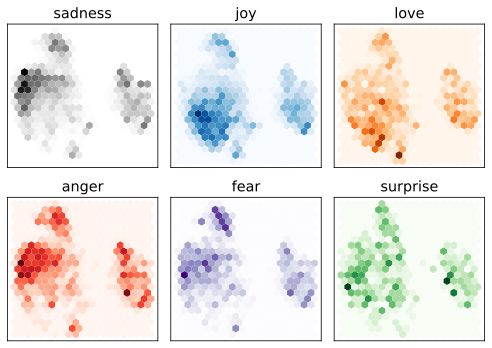

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotion["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### 간단한 분류 모델 훈련하기

- 은닉상태를 사용해 사이킷런의 로지스틱 회귀 모델을 훈련시켜보자.

In [43]:
from sklearn.linear_model import LogisticRegression

# 수렴 보장을 위해 max_iter를 증가시킨다.
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

- 분류 모델의 성능을 조사하기 위해 오차행렬을 살펴보자.

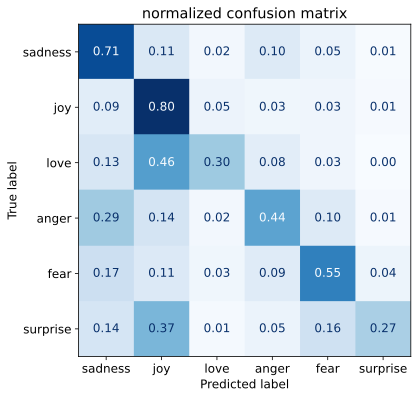

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
labels = emotion["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

### 3.2 트랜스포머 파인튜닝하기

- 이제 트랜스포머를 end-to-end로 파인튜닝하는 조건을 알아보자.
- 파인튜닝 방식에서는 은닉 상태를 고정된 특성으로 사용하지 않고 전체 모델을 훈련한다. 이를 위해 분류 헤드는 미분가능해야한다.


- 트랜스포머스의 Trainer API를 사용해 훈련루프를 간단하게 구현해보자.

#### 사전 훈련된 모델 로드하기

- 첫째로 필요한 요소는 특성 기반 방식에서 사용한 것과 같은 사전훈련된 모델이다.
- 앞과 달리 AutoModel 클래스 대신 AutoModelForSequenceClassification을 사용하겠다.
- AutoModelForSequenceClassification 모델은 사전 훈련된 모델 출력 위에 베이스 모델과 함께 쉽게 훈련할 수 있는 분류 헤드가 있다는 점에서 다르다.
- 분류 헤드의 출력 크기를 설정하기 위해 모델이 예측할 레이블 개수를 지정한다.

In [49]:
from transformers import AutoModelForSequenceClassification

num_lables = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_lables).to(device))

- 모델 일부가 랜덤하게 초기화된다는 경고가 뜬다.
- 분류 헤드가 아직 훈련되지 않았으니 이는 정상.

#### 지표 정의하기

- 학습하는 동안 성능을 모니터링하기 위해 Trainer에 사용한 compute_metrics() 함수를 정의한다.
- 이 함수는 EvalPrediction 객체(predictions와 label_ids 속성을 가진 네임드 튜플)를 입력받아 측정 지표 이름과 값을 매핑한 딕셔너리를 반환한다.

In [50]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    
    return {"accuracy": acc, "f1": f1}

- 데이터셋과 측정 지표가 준비되면 trainer 클래스를 정의하기 전에 마지막으로 두가지만 처리하면 된다.
  1. 허깅페이스 허브에 로그인하여 파인튜닝한 모델을 계정에 저장,
  2. 훈련을 위한 모든 하이퍼파라미터를 정의

#### 모델 훈련하기

- 훈련 파라미터를 정의하기 위해 TrainArguments 클래스를 사용한다.
- 이 클래스는 많은 정보를 저장하며 훈련과 평가를 상세하게 제어한다.
- 가장 중요한 매개변수는 훈련 과정에서 생성된 부산물이 저장될 output_dir.

In [52]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

- 이런 설정으로 Trainer객체를 만들고 모델을 파인튜닝하자.

In [56]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train()

/home/work/.local/lib/python3.8/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/Youngdong2/distilbert-base-uncased-finetuned-emotion into local empty directory.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, o

/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.754920,0.758000,0.702313
2,No log,0.530981,0.826000,0.799301


/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=168, training_loss=0.9277917771112352, metrics={'train_runtime': 176.1, 'train_samples_per_second': 181.715, 'train_steps_per_second': 0.954, 'total_flos': 720342861696000.0, 'train_loss': 0.9277917771112352, 'epoch': 2.0})

- 오차행렬을 만들어 조금 더 상세히 살펴보자.
- 오차행렬을 만들기 위해 먼저 검증 셋에 대한 예측을 만든다.
- Trainer클래스의 predict() 메서드는 평가에 사용할 수 있는 몇 가지 유용한 객체를 반환한다.

In [57]:
preds_output = trainer.predict(emotions_encoded["validation"])

/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [58]:
preds_output.metrics

{'test_loss': 0.5309807658195496,
 'test_accuracy': 0.826,
 'test_f1': 0.799301416779084,
 'test_runtime': 0.8583,
 'test_samples_per_second': 2330.078,
 'test_steps_per_second': 12.815}

- 또 각 클래스에 대한 예측 데이터도 있다.
- np.argmax()함수를 사용해 가장 큰 값이 나오도록 예측을 디코딩한다. 그러면 예측 레이블이 반환되며, 반환된 레이블은 특성 기반 방식에서 사이킷런 모델이 반환한 레이블과 포맷이 같다.

In [59]:
y_preds = np.argmax(preds_output.predictions, axis=1)

- 이 예측을 사용해 오차행렬을 만들자.

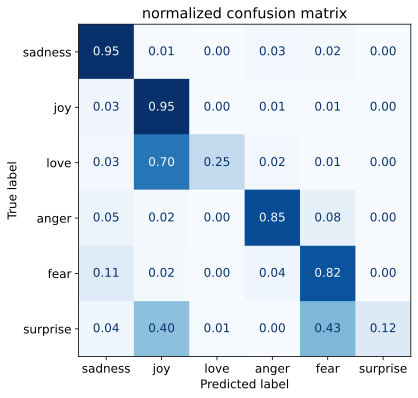

In [60]:
plot_confusion_matrix(y_preds, y_valid, labels)

- 모델이 일으킬 가능성이 있는 오류 유형을 조금 더 분석해보자.

#### 오류 분석

- 간단하지만 강력한 조사방법으로 모델의 손실 기준으로 검증 샘플을 정렬하는 방법이 있다.
- 정방향 패스의 결과와 레이블을 사용하면 손실은 자동으로 계산할 수 있다.
- 다음은 손실과 예측 레이블을 반환하는 함수이다.

In [61]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
        
    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮김.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

- 다시 한번 map() 메서드로 이 함수를 적용해 모든 샘플의 손실을 구한다.

In [62]:
# 데이터셋을 다시 토치 텐서로 변환.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

# 손실 계산
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

- 마지막으로 텍스트, 손실, 예측 레이블과 진짜 레이블로 DataFrame을 만들자.

In [63]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

#### 잘못된 레이블

- 데이터에 레이블을 부여하는 프로세스는 모두 완벽하지 않다.
- 따라서 잘못된 레이블이 있는 것이 정상.


#### 데이터셋의 특이사항

- 텍스트 데이터에서는 입력에 포함된 특수 문자나 문자열이 모델 예측에 큰 영향을 미치기도 한다.
- 모델의 가장 나쁜 예측을 들여다보면 이런 특성을 찾게 되고, 데이터를 정제하거나 비슷한 샘플을 추가하면 모델이 안정된다.
- 먼저 손실이 가장 높은 샘플을 확인하자.

In [64]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,4.397148
303,i was very happy with impact made by valbuena ...,fear,joy,4.336816
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.332753
765,i feel super awkward and out of place right now,joy,sadness,4.226227
1274,i am going to several holiday parties and i ca...,joy,sadness,4.193595
882,i feel badly about reneging on my commitment t...,love,sadness,4.134163
1801,i feel that he was being overshadowed by the s...,love,sadness,4.046529
1950,i as representative of everything thats wrong ...,surprise,sadness,3.962301
1500,i guess we would naturally feel a sense of lon...,anger,sadness,3.891019
465,i would eventually go in to these stores but i...,joy,fear,3.848391


 - 가장 낮은 손실을 내는 예측도 살펴보자.

In [65]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
69,i have no extra money im worried all of the ti...,sadness,sadness,0.082691
861,i am feeling awfully lonely today and i dont w...,sadness,sadness,0.086230
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.086419
189,i leave the meeting feeling more than a little...,sadness,sadness,0.086979
1965,i started feeling pathetic and ashamed,sadness,sadness,0.086989
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.087003
394,i feel shamed that i hoped for one last christ...,sadness,sadness,0.087099
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.087113
66,i look and feel miserable,sadness,sadness,0.088199
1984,i have i feel pathetic for lying if i say no,sadness,sadness,0.088274


#### 모델 저장 및 공유

In [66]:
trainer.push_to_hub(commit_message="Training complated")

Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

Upload file runs/Sep06_09-29-03_main1/events.out.tfevents.1725615144.main1.1606.0:   0%|          | 1.00/4.38k…

To https://huggingface.co/Youngdong2/distilbert-base-uncased-finetuned-emotion
   0a5297c..93f0ae9  main -> main

To https://huggingface.co/Youngdong2/distilbert-base-uncased-finetuned-emotion
   93f0ae9..f608e14  main -> main



'https://huggingface.co/Youngdong2/distilbert-base-uncased-finetuned-emotion/commit/93f0ae9beea36f94b076ef618f81c911bf133668'

- 파인튜닝된 모델을 사용해 새로운 트윗에 대해 예측할 수도 있다.
- 모델을 허브에 업로드했으니 pipeline() 함수를 사용해보자.

In [67]:
from transformers import pipeline

model_id = "Youngdong2/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

TAPAS models are not usable since `torch_scatter` can't be loaded.It seems you have `torch_scatter` installed with the wrong CUDA version.Please try to reinstall it following the instructions here: https://github.com/rusty1s/pytorch_scatter.


- 샘플 트윗으로 이 파이프라인을 테스트해보자.

In [69]:
custom_tweet = "I saw a movie today and it was reallt good."
pred = classifier(custom_tweet)

In [70]:
pred

[{'label': 'LABEL_1', 'score': 0.8736366033554077}]

In [72]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']